In [3]:
###Required packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import scipy.stats as st


In [4]:
#Read in raw data
single_arch_perturb = pd.read_csv('kinetic_perturbation_total.csv')
single_arch_background = pd.read_csv('background.csv')

In [5]:
#Filter for only Dual Control bits 
dc_perturbed = single_arch_perturb.loc[single_arch_perturb.Circuit == 'Dual Control']
dc_background = single_arch_background.loc[single_arch_background.Circuit == 'Dual Control']

In [6]:
#Recompute best loss on non-error samples
start=0
stop=1000
background = pd.DataFrame(columns=dc_background.columns)
for j in range(100):
    landscape = dc_background.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] > 0:
            best_loss = landscape.loss[i]
            best_row = landscape.loc[landscape['index'] == i]
    background = pd.concat([background, best_row])
    start = stop
    stop += 1000

start=0
stop=1000
perturb = pd.DataFrame()
for j in range(1000):
    landscape = dc_perturbed.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] > 0:
            best_loss = landscape.loss[i]
            best_row = landscape.loc[landscape['index'] == i]
    perturb = pd.concat([perturb, best_row])
    start = stop
    stop += 1000

background = background.reset_index()
perturb = perturb.reset_index()

In [15]:
#Dose response curves
conf = 0.90
color1= (96/255,151/255, 198/255) #light
color2 = (22/255,56/255,104/255) #dark

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)

xs = np.arange(0, 25, 0.001)

#Compute dose-response curves for all optimal param values
y1s=[]; y2s = []
for i in range(100):
    y1s.append(repression(xs, background.k1[i], background.theta1[i], 2.))
    y2s.append(activation(xs, background.k2[i], background.theta2[i], 2.))
y1s = np.array(y1s); y2s = np.array(y2s)

mean_y1 = [np.mean(y1s[:, j]) for j in range(len(xs))]
mean_y2 = [np.mean(y2s[:, j]) for j in range(len(xs))]
ci1 = np.array([st.norm.interval(confidence=conf, loc=np.mean(y1s[:, j]), scale=st.sem(y1s[:, j])) for j in range(y1s.shape[1])])
ci2 = np.array([st.norm.interval(confidence=conf, loc=np.mean(y2s[:, j]), scale=st.sem(y2s[:, j])) for j in range(y2s.shape[1])])

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


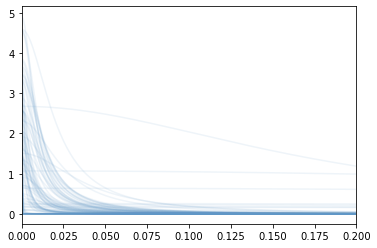

In [37]:
for i in range(100):
    plt.plot(xs, y1s[i, :], color=color1, alpha=0.1)
    plt.xlim([0, 0.2])

(0, 1)

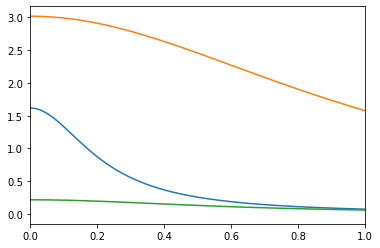

In [33]:
plt.plot(xs, repression(xs, background.k1.mean(), background.theta1.mean(), 2.))
plt.plot(xs, repression(xs, background.k1.mean() + background.k1.std(), background.theta1.mean() + background.theta1.std(), 2.))
plt.plot(xs, repression(xs, background.k1.mean()  - background.k1.std(), background.theta1.mean() -  background.theta1.std(), 2.))

plt.xlim([0, 1])

In [35]:
background.k2.mean()  - background.k2.std()

-0.6661552480170239

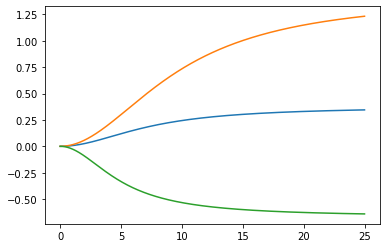

In [34]:
plt.plot(xs, activation(xs, background.k2.mean(), background.theta2.mean(), 2.))
plt.plot(xs, activation(xs, background.k2.mean() + background.k2.std(), background.theta2.mean() + background.theta2.std(), 2.))
plt.plot(xs, activation(xs, background.k2.mean()  - background.k2.std(), background.theta2.mean() -  background.theta2.std(), 2.))


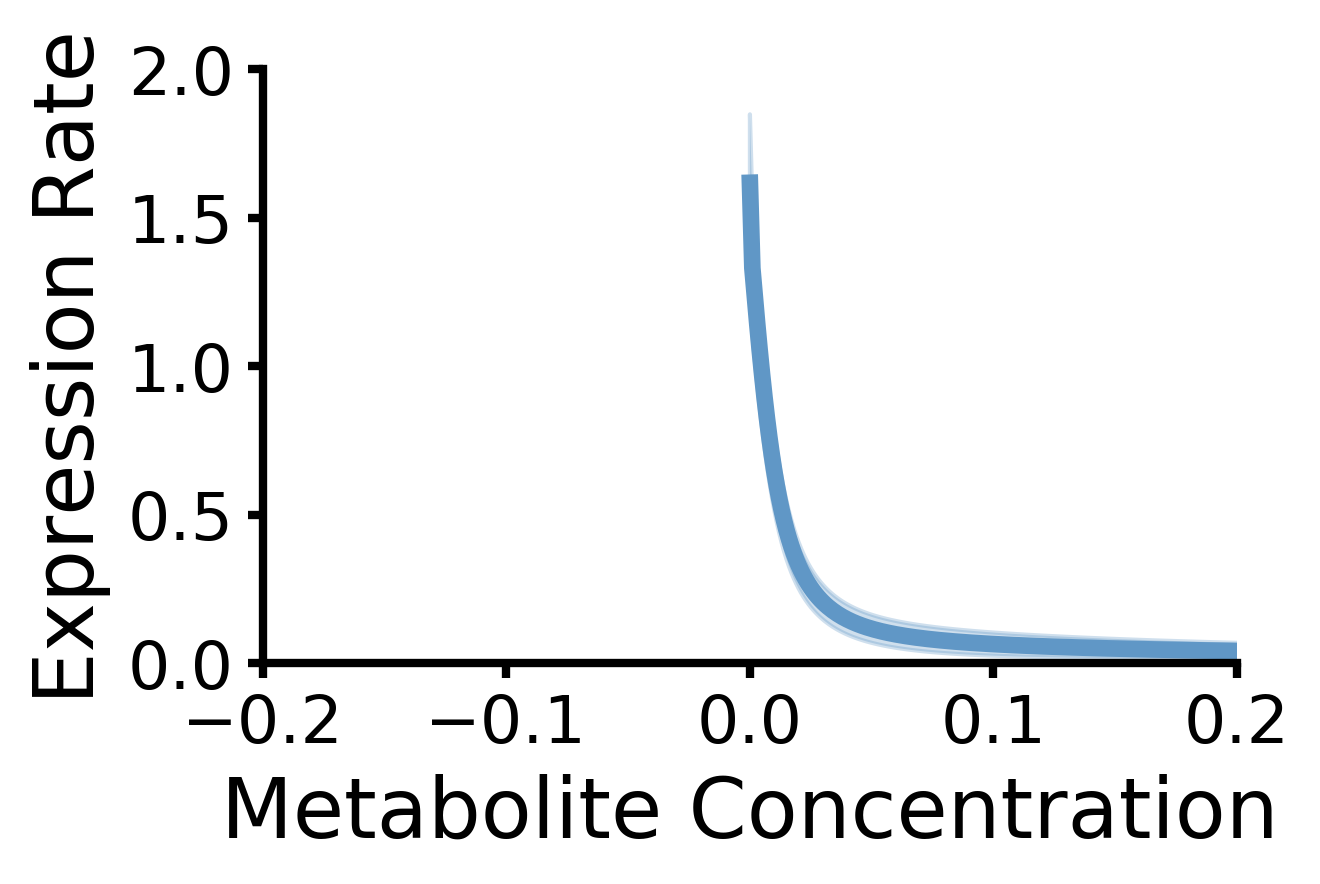

In [27]:
fig, axs = plt.subplots(1,1,figsize=(4.5, 3), dpi=300)
ax = axs
ax.plot(xs, mean_y1, c=color1, linewidth=4)
ax.fill_between(xs, ci1[:, 0], ci1[:, 1], alpha=0.3, color=color1)

# ax.plot(xs, mean_y2, c=color2, linewidth=4)
# ax.fill_between(xs, ci2[:, 0], ci2[:, 1],  alpha=0.3, color=color2)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
#ax.set(yticks=[2], xticks=[0, 10, 20])
ax.set_ylim([0, 2])
ax.set_xlim([-0.2, 0.2])
ax.set_xlabel('Metabolite Concentration', fontsize=20)
ax.set_ylabel('Expression Rate', fontsize = 20)
fig.tight_layout()
#ax.set_xscale('log')
#fig.savefig('dose_response_curves.png', dpi=300, bbox_inches='tight', pad_inches=0.)


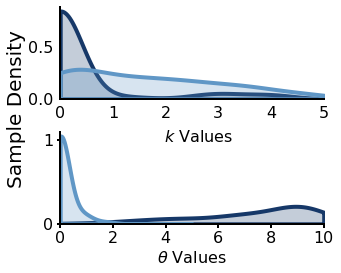

In [221]:
#Parameter distributions
fig, axs = plt.subplots(2,1,figsize=(3.5*1.3, 3*1.3))
ax = axs[0]
sns.kdeplot(background.k2, clip=[0, 5], fill=True, color=color2, ax=ax, linewidth=4)
sns.kdeplot(background.k1, clip=[0, 5], fill=True, color=color1, ax=ax, linewidth=4)

ax.set_xlim([0, 5])
#ax.set_ylim([0, 0.55])

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('')
# ax.set_xlabel(r'$k$ Values', fontsize=16)
fig.text(0.45, 0.50, r'$k$ Values', va='center', rotation='horizontal', fontsize=16)
ax.set_xlabel('')
ax.tick_params(width=0)
ax = axs[1]
ax.set_xlim([0, 10])
sns.kdeplot(background.theta2, clip=[0, 10], fill=True, color=color2, ax=ax, linewidth=4)
sns.kdeplot(background.theta1, clip=[0, 5], fill=True, color=color1, ax=ax, linewidth=4)

#ax.set_ylim([0, 0.55])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(width=2)
ax.set_xlabel(r'$\theta$ Values', fontsize=16)
ax.set_ylabel('')
fig.text(-0.03, 0.6, 'Sample Density', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
#fig.savefig('drc_distributions.png', dpi=300, bbox_inches='tight', pad_inches=0.)



In [6]:
print(background.theta1.mean())

0.2168283462260456


In [7]:
print(background.theta2.mean())

7.305799647740941
